# Parameter Scans

In this notebook we will cover the Parameter Scan functionality within `abm.simulate(...)`. This functionality allows for submission of simulations in which one or more parameter values are changed (either to a specific value or by a specific fold) from the nominal values. Within this notebook we will cover:

- One at a time parameter scans
- Scans over parameter tuples (changing multiple parameters simultaneously)
- Scans over a parameter grid

# Example Model

For this notebook we will use the same model and nominal parameter set as for the Simulations Notebook. You may use either the model file you created, or the "answers" model file (`../Model_Files/ModelFile_answers.txt`) and the provided parameter table (`../Tables/ParameterTable.csv`)

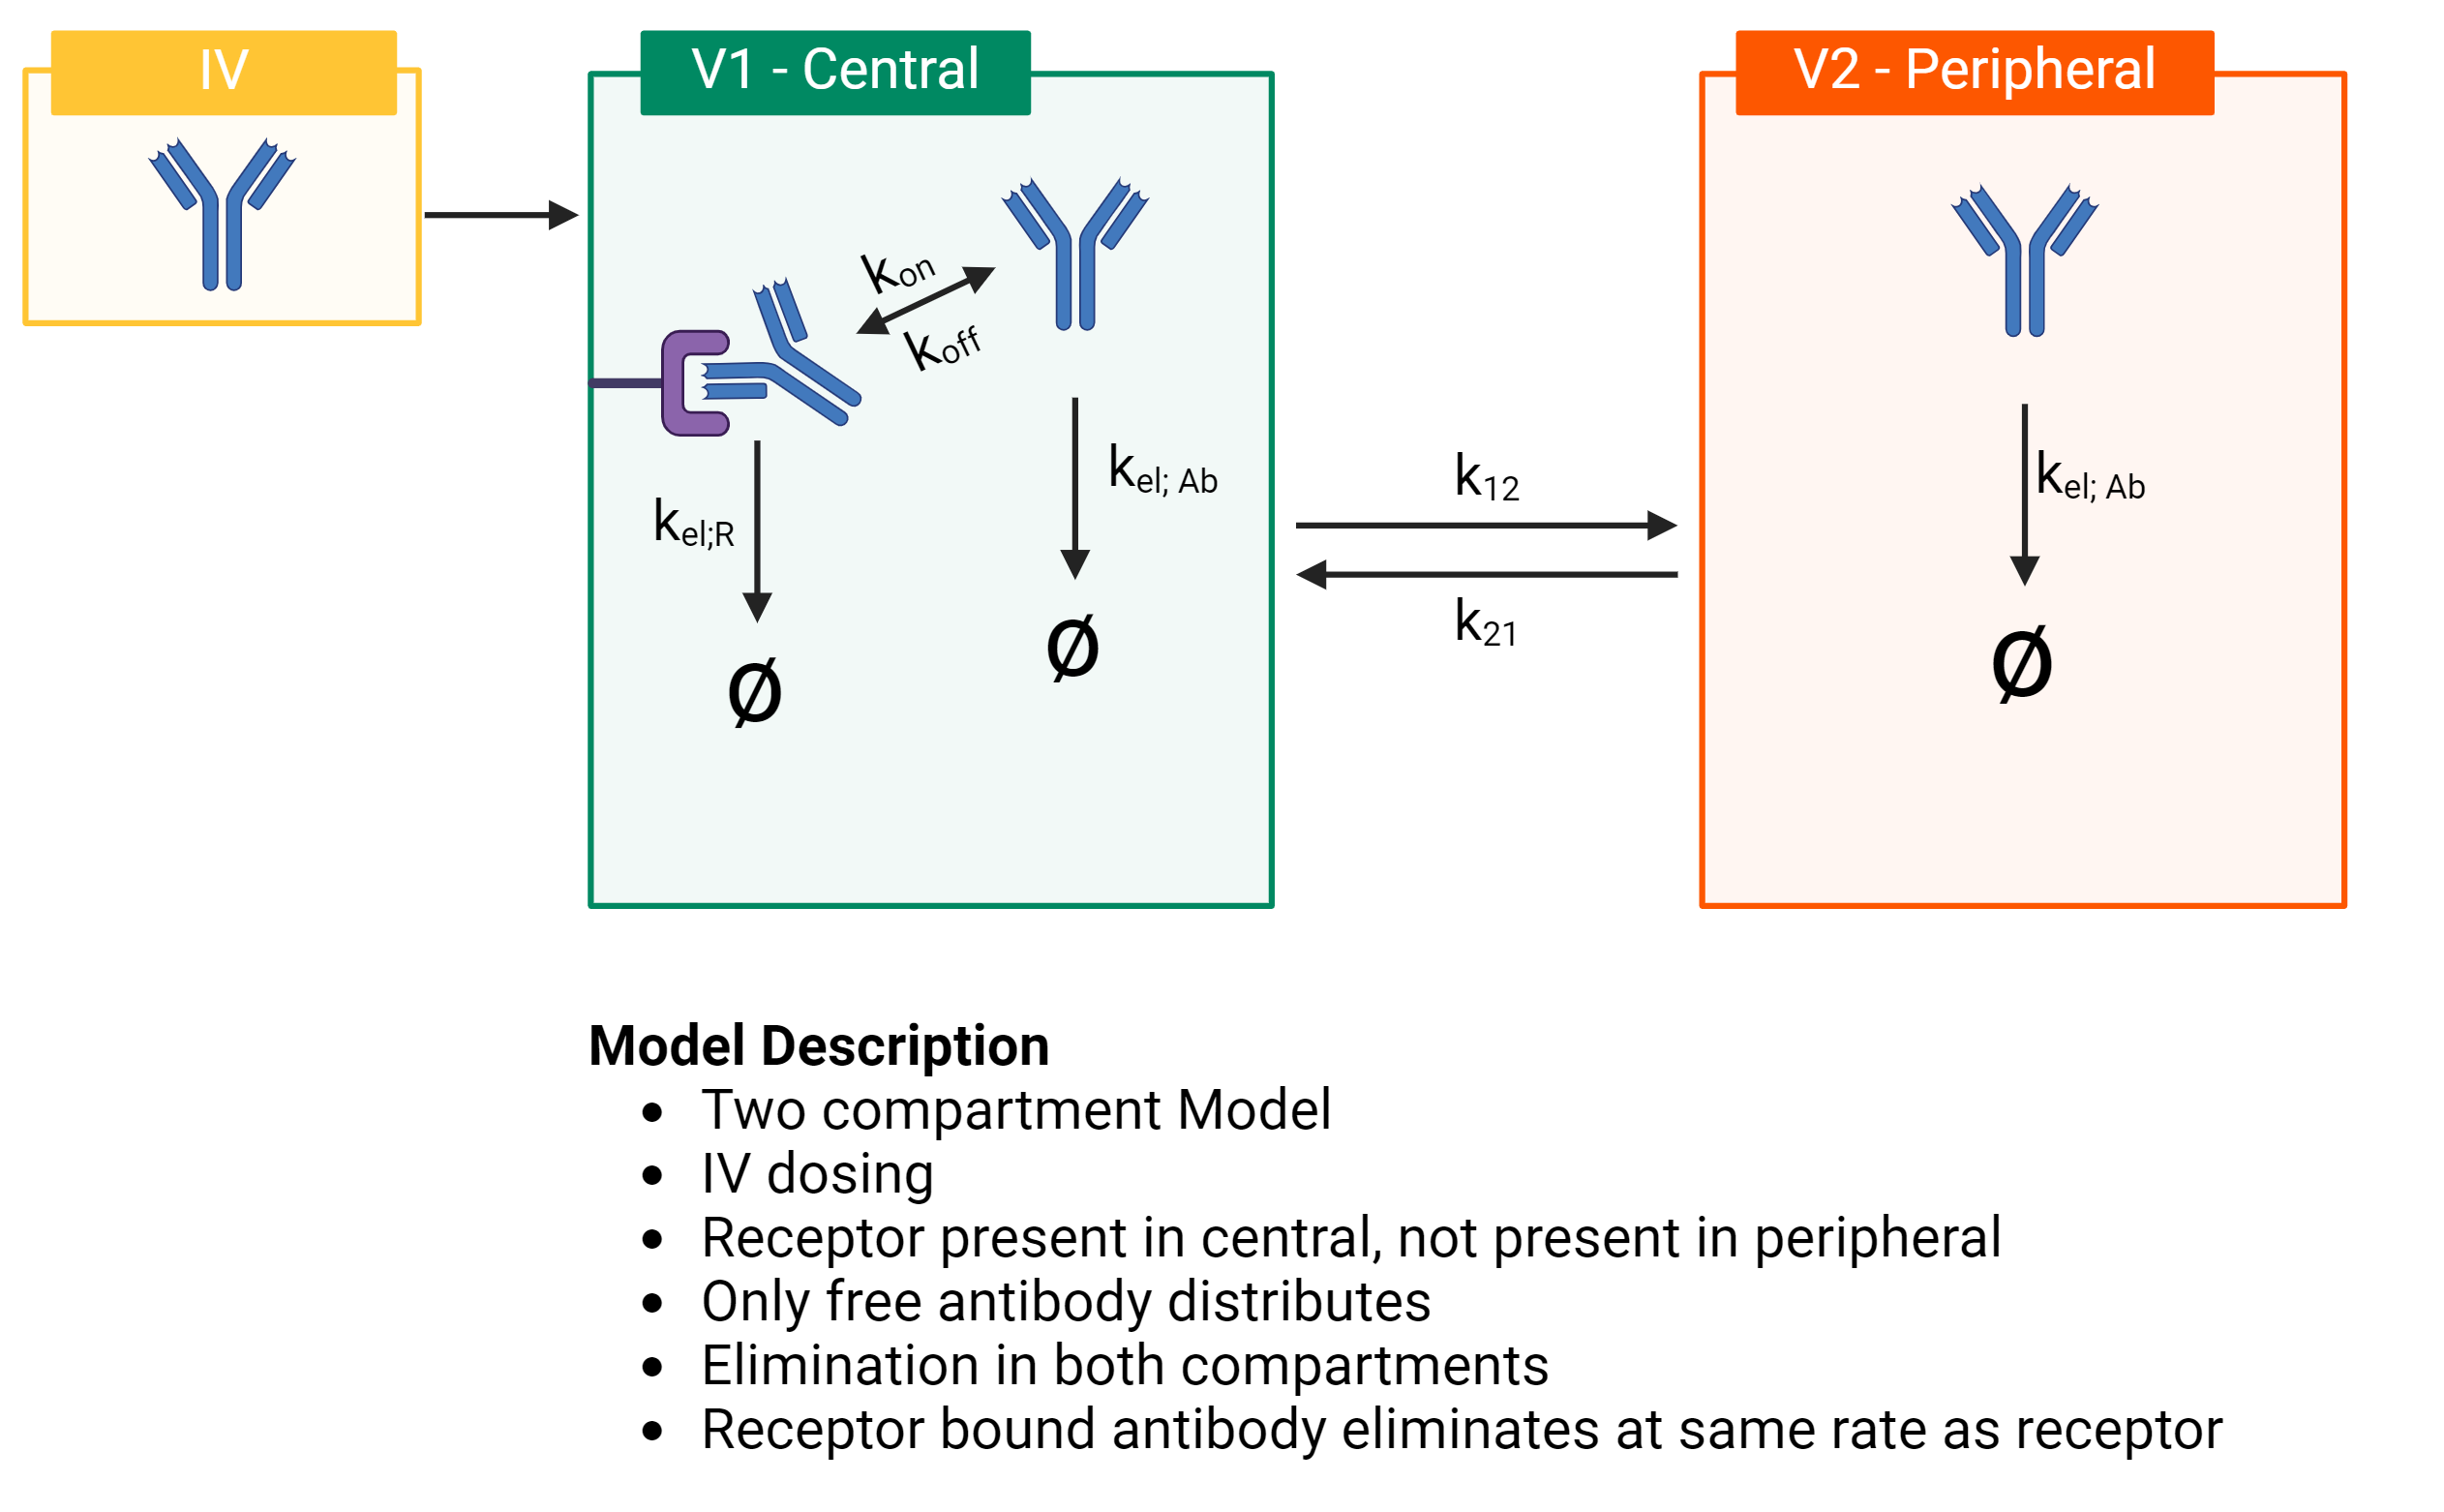

# Set up
Before beginning any modeling, we must load the necessary packages. It is also usually a good idea to load and view your parameter tables

## Set up task
 - Load `numpy` and `pandas` using a "short" name
 - Load `plotnine` and `abm` with whichever method you prefer
 - Load and display the parameter table (`../Tables/ParameterTable.csv`)
 - Load and display the dose and simulations tables you generated in the "Simulations" Notebook (or use the answer key files - `../Tables/DoseTable_filled.csv`, `../Tables/SimulationTable_filled.csv`)

In [1]:
import numpy as np
import pandas as pd
from plotnine import *
from abm import *

In [2]:
Tpar = pd.read_csv('../Tables/ParameterTable.csv')
display(Tpar)

,parameter,unit,value
0,volume_central,L,5.000
1,volume_peripheral,L,13.000
2,R_per_cell,1,10000.000
3,cell_per_mL,1/mL,1000000.000
4,kon,1/nM/s,0.001
5,kd_mab,nM,0.100
6,el_half,d,28.000
7,R_half,min,60.000
8,Pdist,1,0.120
9,Tdist_hr,hr,12.000


In [3]:
Tdos = pd.read_csv('../Tables/DoseTable_filled.csv')
Tsim = pd.read_csv('../Tables/SimulationTable_filled.csv')

display(Tdos)
display(Tsim)

,dose_mpk,route,amounts,amount_unit,times,time_unit
0,0.01,IV_mpk,0.01,mg/kg,"[0,7,14]",d
1,0.03,IV_mpk,0.03,mg/kg,"[0,7,14]",d
2,0.10,IV_mpk,0.10,mg/kg,"[0,7,14]",d
3,0.30,IV_mpk,0.30,mg/kg,"[0,7,14]",d


,dose_mpk
0,0.01
1,0.03
2,0.10
3,0.30


# Parameter Scans

When only simulating nominal parameters our simulation code looked like so:

```
simulate(models = {Model File},
        parameters = {Parameter Table},
        doses = {Dose Table},
        simulations = {Simulation Table},
        outputs = {Output List},
        times = {Times List or Table}).to_pandas(tall_outputs = True)
```

If we want to scan a parameter, we add an imput into the simulate function so that it looks like so:

```
simulate(models = {Model File},
        parameters = {Parameter Table},
        doses = {Dose Table},
        simulations = {Simulation Table},
        outputs = {Output List},
        times = {Times List or Table},
        scans = {Scan Information}).to_pandas(tall_outputs = True)
```

The scan information can be entered as either :
- a `fold_scan` in which case the nominal parameter is multiplied by the fold value
    - Fold scans do not take units as the fold value is a unitless quantity
    - Scan entries are a list of floats or ints
- a `value_scan` in which case the nominal parameter is replaced by the value
    - One option for scan entries are a list of strings of the form `"value:units"`. This allows you to enter a value for your parameter in a different unit than the nominal value. Though the units in this option must be the same as either the units in the model or the units in the parameter table!
    - A second option for scan entries are a list of floats or ints. This requires that the units of the new parameter values are the same as the nominal parameter value.

For both `value_scan` and `fold_scan` options, the scan input is entered with the syntax `XXX_scan(parameter = {scan entry list})` where `XXX` is either `value` or `fold`.

The output table of a parameter scan looks very similar to the output table of a simulation. There are an additional three (or more) columns:

1. `param_scan_0` stors the name of the parameter being scanned
2. `scan_0_value` stores the value of the scanned parameter for this row's simulation
3. `scan_0_fold` stors the fold change of the scanned parameter relative to the nominal value for this row's simulation

If you scan multiple parameters sequentially, they will all be listed in the `param_scan_0` column. If you scan multiple parameters simultaneously, they will each be assigned their own set of columns (the numerical portion of the names of these columns changing)

## One at a Time Parameter Scans

One at a time parameter scans are often performed as a method for local sensitivity analysis. In this case you would change the value of the first parameter while keeping the others at the nominal value, then you'd revert the first parameter to its nominal value and change the value of the second parameter, and so on.

For such an analysis you would "add" together the scan information in the scan input of your simulation object with this syntax:

```
simulate(models = {Model File},
        parameters = {Parameter Table},
        doses = {Dose Table},
        simulations = {Simulation Table},
        outputs = {Output List},
        times = {Times List or Table},
        scans = XXX_scan(parameter1 = {scan1 entry list}
              + XXX_scan(parameter2 = {scan2 entry list}).to_pandas(tall_outputs = True)
```

The sum of scans would continue until you have listed all parameters you wish to scan over.

### Single Parameter Scan Task
For this task we will use only the 0.1 mg/kg dose in our simulation.

1.  Create a shortened `Tsim_single` which is just the 0.1 mg/kg row of your original simulation table
    - You can do this either with `query` or by creating a new table from scratch

2.  Use a fold scan to simulate the RO with 0.5x, 2x, and 1x values of kd_mab parameter with output times given by `linspace(0,21,211,'d')`
    - Plot the results
        - Use color to distinguish the different scanned parameter values
 

3.  Use a value scan to simulate the RO with the same values and output times as above (note 0.1 nM is the nominal Kd value)
    - Plot the results
        - Use color to distinguish the different scanned parameter values

In [4]:
Tsim_single = Tsim.query('dose_mpk == 0.1')
display(Tsim_single)

,dose_mpk
2,0.1


In [5]:
Tfold = simulate(models = '../Model_Files/ModelFile_answers.txt',
                parameters = Tpar,
                doses = Tdos,
                simulations = Tsim_single,
                outputs = ['RO1'],
                times = linspace(0,21,211,'d'),
                scans = fold_scan(kd_mab = [0.5, 1, 2])).to_pandas(tall_outputs = True)

display(Tfold.head())

Total: 4, Running: 0, Succeeded: 4, Failed: 0

,dose_mpk,scan_0_type,id,param_scan_0,scan_0_value,scan_0_fold,t,output,value,output_unit
0,0.1,fold,0,kd_mab,0.05,0.5,0.0,RO1,0.000000,1
1,0.1,fold,0,kd_mab,0.05,0.5,8640.0,RO1,97.371791,1
2,0.1,fold,0,kd_mab,0.05,0.5,17280.0,RO1,97.284497,1
3,0.1,fold,0,kd_mab,0.05,0.5,25920.0,RO1,97.202270,1
4,0.1,fold,0,kd_mab,0.05,0.5,34560.0,RO1,97.125054,1


/home/jovyan/abm-platform-training/.venv/lib/python3.12/site-packages/plotnine/geoms/geom_path.py:100: PlotnineWarning: geom_path: Removed 1 rows containing missing values.


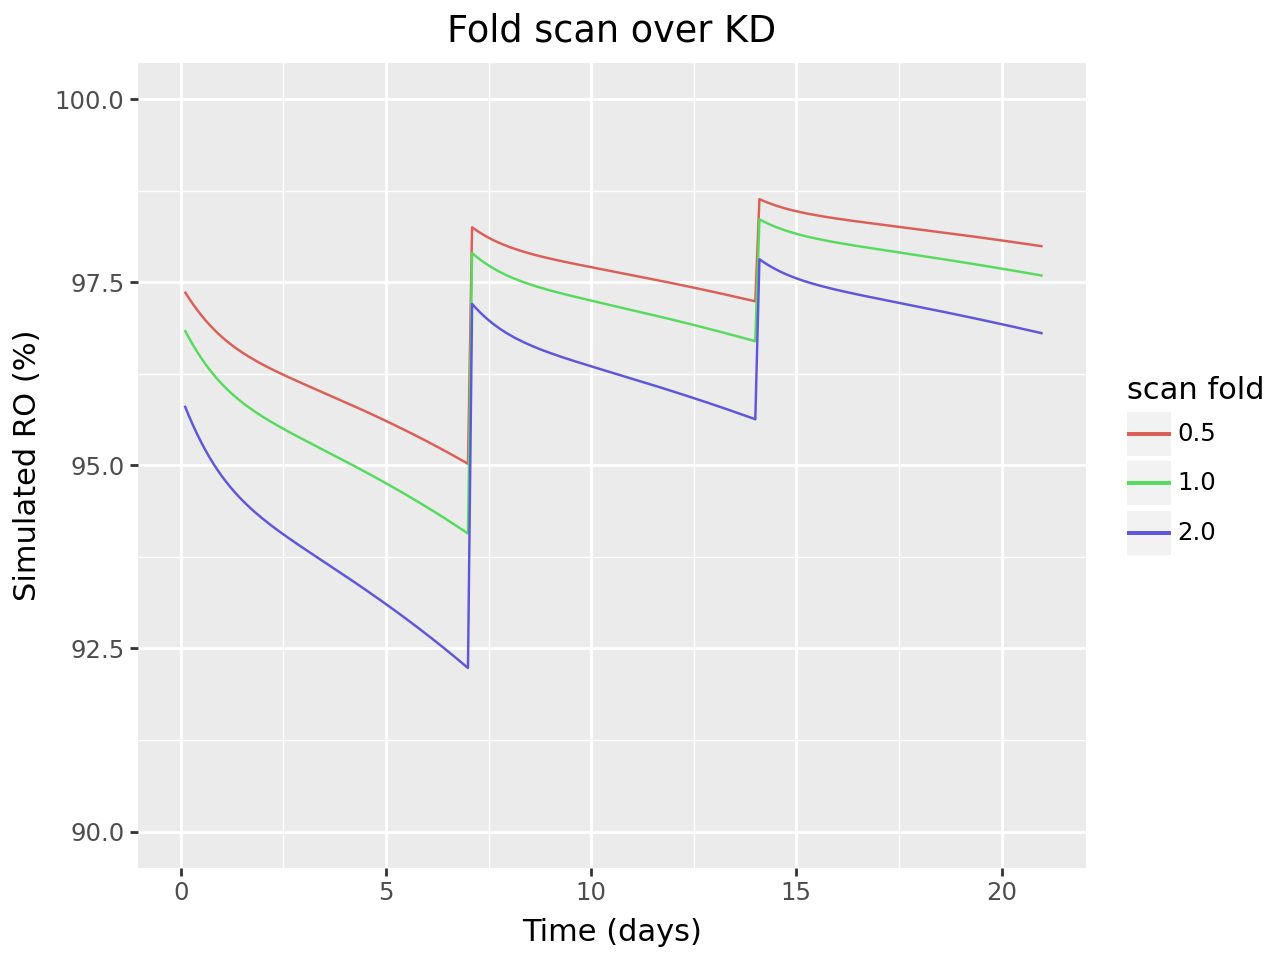

In [6]:
fig = (ggplot()
       + geom_line(data = Tfold, mapping = aes(x = 't/(3600*24)', y = 'value', color = 'factor(scan_0_fold)'))
       + labs(x = 'Time (days)', y = 'Simulated RO (%)', color = 'scan fold', title = 'Fold scan over KD')
       + scale_y_continuous(limits = [90,100])
)

fig.show()

In [7]:
Tvalue = simulate(models = '../Model_Files/ModelFile_answers.txt',
                parameters = Tpar,
                doses = Tdos,
                simulations = Tsim_single,
                outputs = ['RO1'],
                times = linspace(0,21,211,'d'),
                scans = value_scan(kd_mab = ['0.05:nM', '0.1:nM', '0.2:nM'])).to_pandas(tall_outputs = True)

display(Tvalue.head())

Total: 4, Running: 0, Succeeded: 4, Failed: 0

,dose_mpk,scan_0_type,id,param_scan_0,scan_0_value,scan_0_fold,t,output,value,output_unit
0,0.1,value,0,kd_mab,0.05,0.5,0.0,RO1,0.000000,1
1,0.1,value,0,kd_mab,0.05,0.5,8640.0,RO1,97.371791,1
2,0.1,value,0,kd_mab,0.05,0.5,17280.0,RO1,97.284497,1
3,0.1,value,0,kd_mab,0.05,0.5,25920.0,RO1,97.202270,1
4,0.1,value,0,kd_mab,0.05,0.5,34560.0,RO1,97.125054,1


/home/jovyan/abm-platform-training/.venv/lib/python3.12/site-packages/plotnine/geoms/geom_path.py:100: PlotnineWarning: geom_path: Removed 1 rows containing missing values.


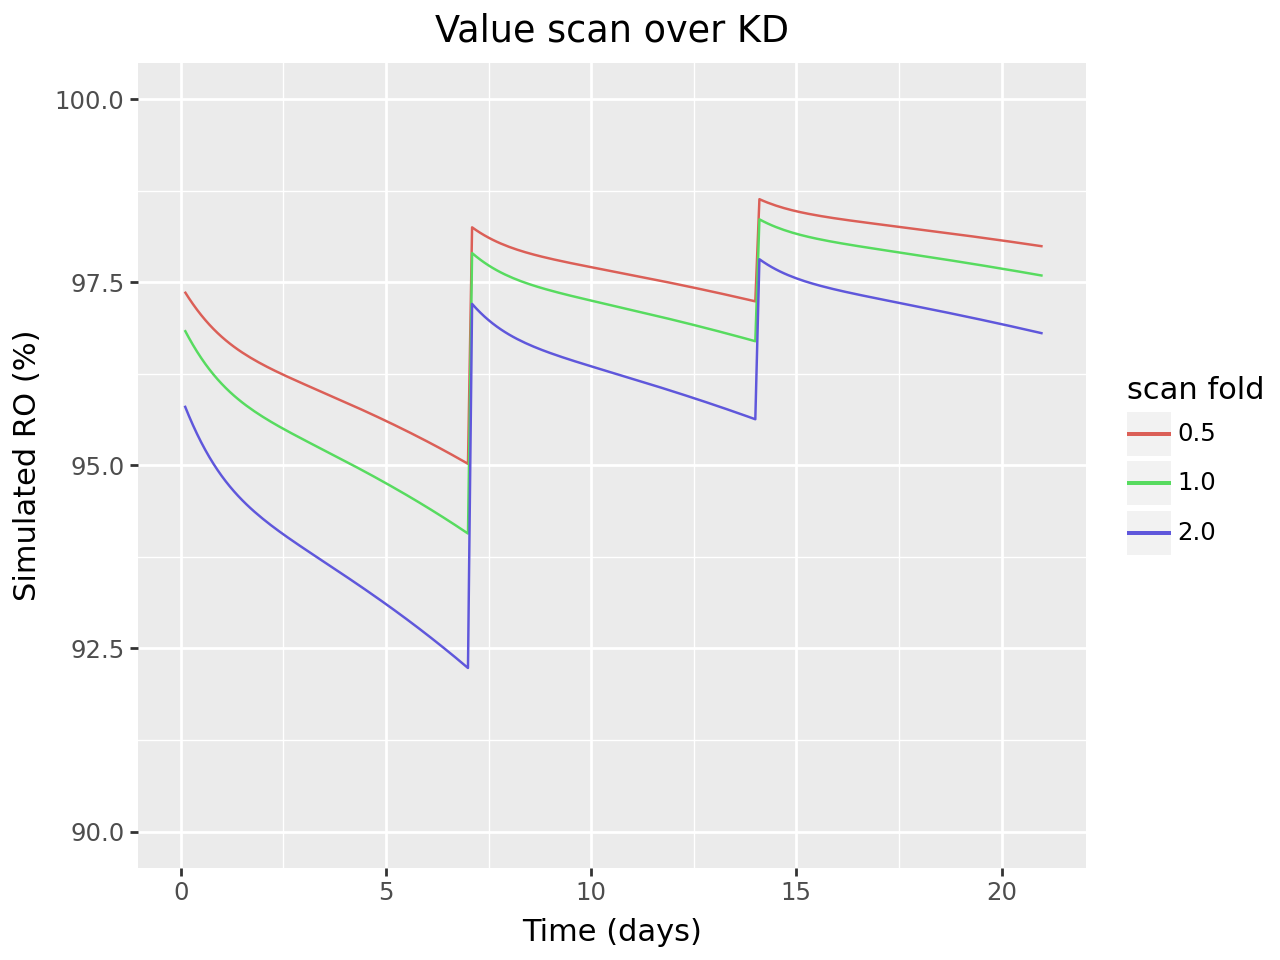

In [8]:
fig = (ggplot()
       + geom_line(data = Tvalue, mapping = aes(x = 't/(3600*24)', y = 'value', color = 'factor(scan_0_fold)'))
       + labs(x = 'Time (days)', y = 'Simulated RO (%)', color = 'scan fold', title = 'Value scan over KD')
       + scale_y_continuous(limits = [90,100])
)

fig.show()

### Sequential Two Parameter Scan Task

- Use a fold scan to simulate the ROwith output times given by `linspace(0,21,211,'d')` for parameter scans over:
    1. 0.5x, 1x, 2x kd_mab
    2. 0.5x, 1x, 2x el_half 
- Plot the results
    - Use color to distinguish the different scanned parameter values
    - Use the scanned parameter name to "facet" the plot

In [9]:
Tseq = simulate(models = '../Model_Files/ModelFile_answers.txt',
                parameters = Tpar,
                doses = Tdos,
                simulations = Tsim_single,
                outputs = ['RO1'],
                times = linspace(0,21,211,'d'),
                scans = fold_scan(kd_mab = [0.5, 1, 2]) +
                        fold_scan(el_half = [0.5, 1, 2])).to_pandas(tall_outputs = True)

display(Tseq.head())

Total: 6, Running: 0, Succeeded: 6, Failed: 0

,dose_mpk,scan_0_type,id,param_scan_0,scan_0_value,scan_0_fold,t,output,value,output_unit
0,0.1,fold,0,kd_mab,0.05,0.5,0.0,RO1,0.000000,1
1,0.1,fold,0,kd_mab,0.05,0.5,8640.0,RO1,97.371791,1
2,0.1,fold,0,kd_mab,0.05,0.5,17280.0,RO1,97.284497,1
3,0.1,fold,0,kd_mab,0.05,0.5,25920.0,RO1,97.202270,1
4,0.1,fold,0,kd_mab,0.05,0.5,34560.0,RO1,97.125054,1


/home/jovyan/abm-platform-training/.venv/lib/python3.12/site-packages/plotnine/geoms/geom_path.py:100: PlotnineWarning: geom_path: Removed 1 rows containing missing values.


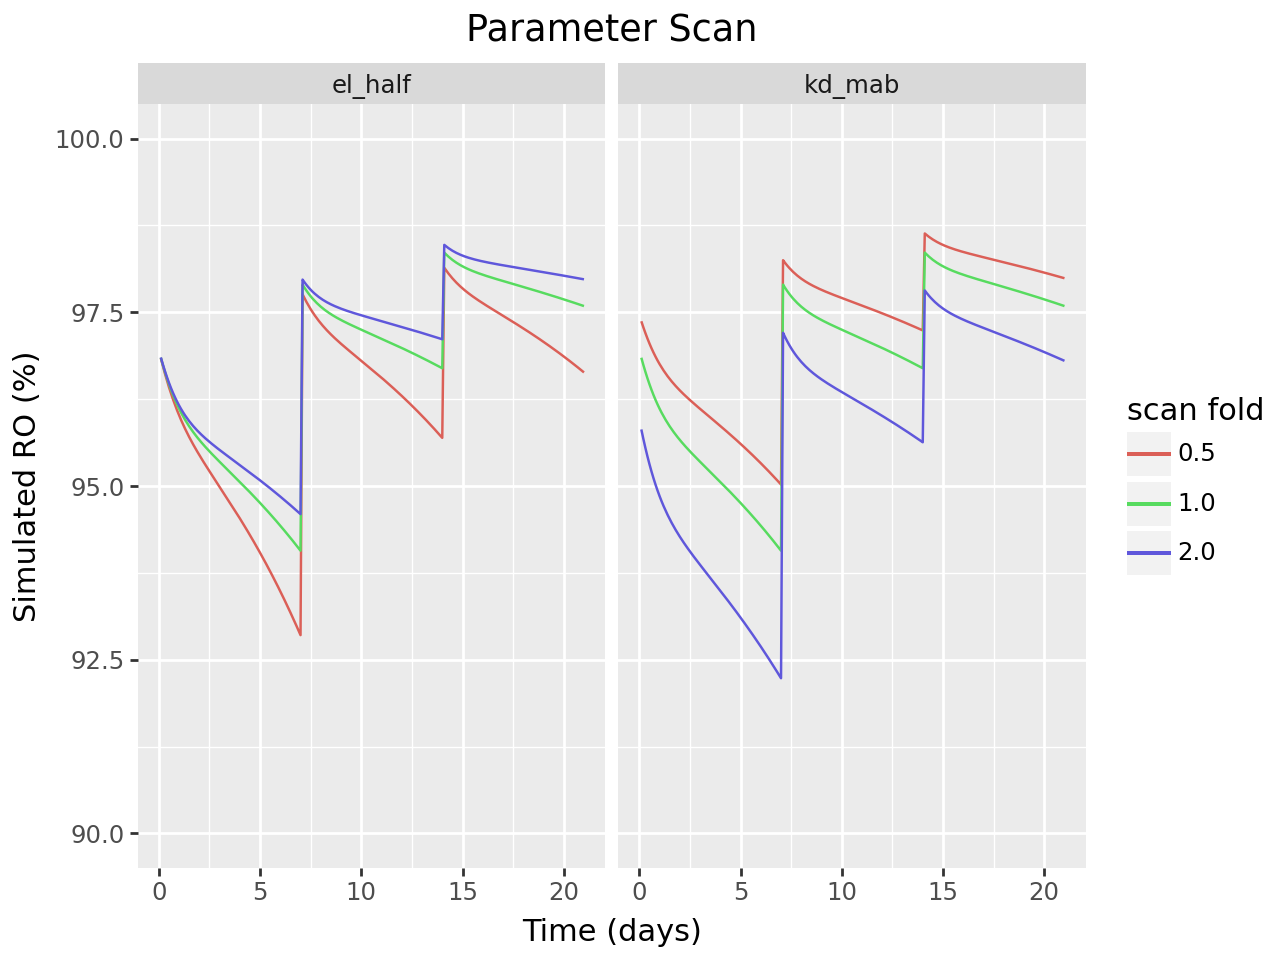

In [10]:
fig = (ggplot()
       + geom_line(data = Tseq, mapping = aes(x = 't/(3600*24)', y = 'value', color = 'factor(scan_0_fold)'))
       + labs(x = 'Time (days)', y = 'Simulated RO (%)', color = 'scan fold', title = 'Parameter Scan')
       + facet_wrap('param_scan_0')
       + scale_y_continuous(limits = [90,100])
)

fig.show()

## Parameter Set Scans

It is often the case that parmeters can only ba changed together. For example, you may be scanning over analogs with specific pairs of parameter values (so analog A has Kd_A and el_half_B while analog B has Kd_B and el_half_B). Or possibly the parameters themselves are correleted in some way. To create a scan where parameters are changed together you use the syntax `XXX_scan(parameter1 = {list of scan entries}, parameter1 = {list of scan entries})`.

Note, you can NOT mix together a fold and value scan in this method. Both lists of scan entries must be the same length!

### Parameter Set Scan Task
- Simulate RO at 0.1 mg/kg for output times `linspace(0,21,211,'d')` using `fold_scan` to sample the parameter sets:
    - (kd_mab x2, el_half x2)
    - (kd_mab x1, el_half x1)
    - (kd_mab x0.5, el_half x0.5)
- Plot the results
    - Create a new label column that combines the fold or value of both scanned parameters to color code the three separate parameter sets you created
        - Hint, you can write a function and apply it to columns of a data frame by using `DataFrame.apply(function, axis = 1)`

In [11]:
Tset = simulate(models = '../Model_Files/ModelFile_answers.txt',
                parameters = Tpar,
                doses = Tdos,
                simulations = Tsim_single,
                outputs = ['RO1'],
                times = linspace(0,21,211,'d'),
                scans = fold_scan(kd_mab = [0.5, 1, 2], el_half = [0.5, 1, 2])).to_pandas(tall_outputs = True)

def label(df):
    return df.param_scan_0 + ' x' + str(df.scan_0_fold) + ', ' + df.param_scan_1 + ' x' + str(df.scan_1_fold)
    
Tset['label'] = Tset.apply(label, axis = 1)
display(Tset.head())

Total: 4, Running: 0, Succeeded: 4, Failed: 0

,dose_mpk,scan_0_type,scan_1_type,id,param_scan_0,scan_0_value,scan_0_fold,param_scan_1,scan_1_value,scan_1_fold,t,output,value,output_unit,label
0,0.1,fold,fold,0,kd_mab,0.05,0.5,el_half,14.0,0.5,0.0,RO1,0.000000,1,"kd_mab x0.5, el_half x0.5"
1,0.1,fold,fold,0,kd_mab,0.05,0.5,el_half,14.0,0.5,8640.0,RO1,97.365522,1,"kd_mab x0.5, el_half x0.5"
2,0.1,fold,fold,0,kd_mab,0.05,0.5,el_half,14.0,0.5,17280.0,RO1,97.271440,1,"kd_mab x0.5, el_half x0.5"
3,0.1,fold,fold,0,kd_mab,0.05,0.5,el_half,14.0,0.5,25920.0,RO1,97.182012,1,"kd_mab x0.5, el_half x0.5"
4,0.1,fold,fold,0,kd_mab,0.05,0.5,el_half,14.0,0.5,34560.0,RO1,97.097213,1,"kd_mab x0.5, el_half x0.5"


/home/jovyan/abm-platform-training/.venv/lib/python3.12/site-packages/plotnine/geoms/geom_path.py:100: PlotnineWarning: geom_path: Removed 1 rows containing missing values.


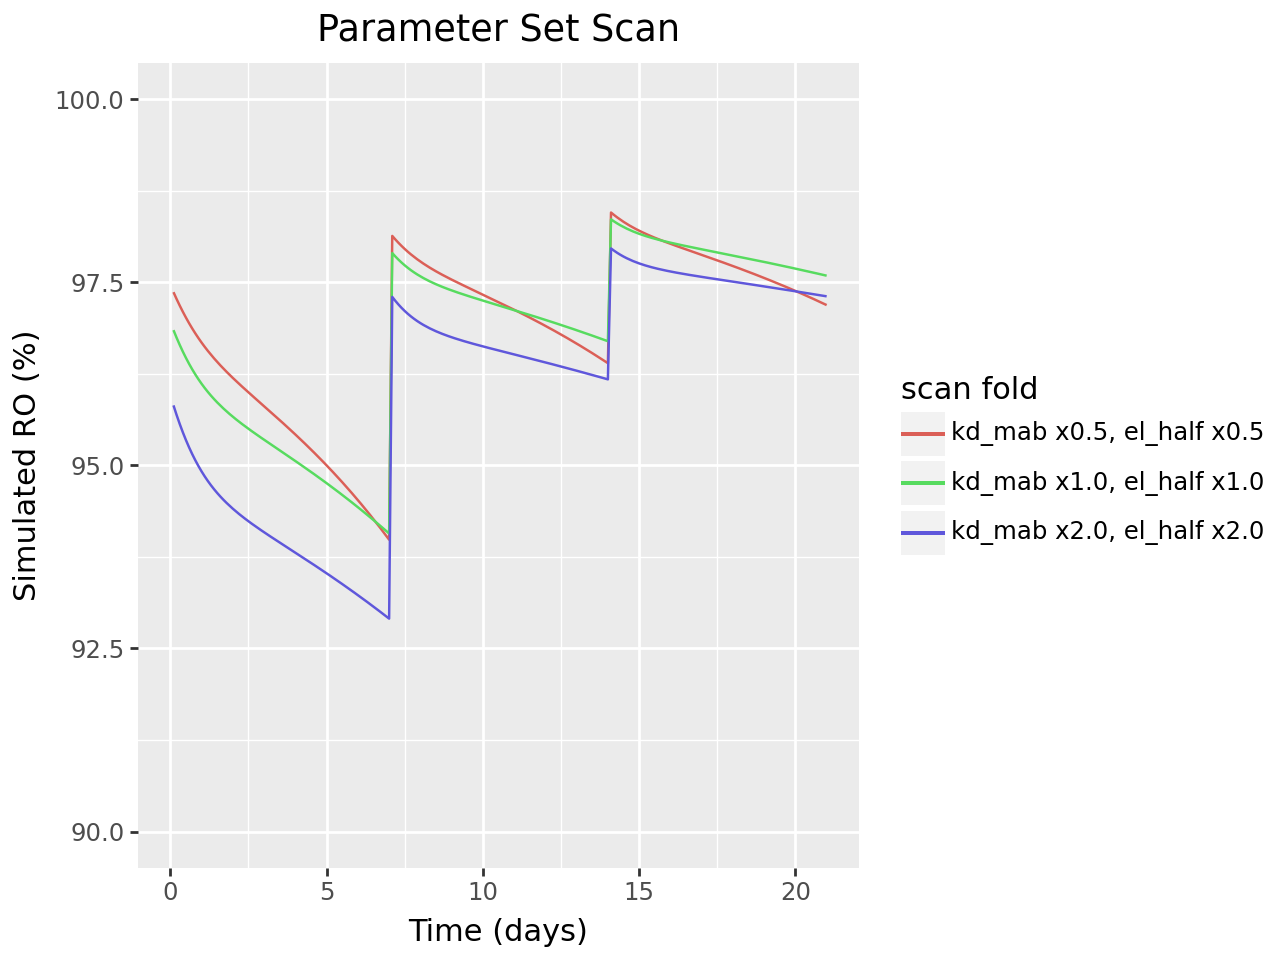

In [12]:
fig = (ggplot()
       + geom_line(data = Tset, mapping = aes(x = 't/(3600*24)', y = 'value', color = 'factor(label)'))
       + labs(x = 'Time (days)', y = 'Simulated RO (%)', color = 'scan fold', title = 'Parameter Set Scan')
       + scale_y_continuous(limits = [90,100])
)

fig.show()

## Parameter Grid Scans
When looking at multiple parameter scans, we often want to calculate every combination of scanned parameter values. This is particularly convenient to plot over a grid where the horizontal and vertical placement of a plot corresponds to the first and second parameter values. This sort of grid scan is often useful when creating a heat map with the color corresponding to some statistic of your simulation and the x and y position corresponding to parameter values.

For this notebook, we will keep things simple and create a grid scan to demonstrate how the time series of multiple doses reacts to changing parameter values.

The syntax of a grid scan is set up as a multiplication of scans:

```
simulate(models = {Model File},
        parameters = {Parameter Table},
        doses = {Dose Table},
        simulations = {Simulation Table},
        outputs = {Output List},
        times = {Times List or Table},
        scans = XXX_scan(parameter1 = {scan1 entry list}
              * XXX_scan(parameter2 = {scan2 entry list}).to_pandas(tall_outputs = True)
```

### Parameter Grid Scan Task

- Simulate RO at 0.01, 0.03, 0.1, and 0.3 mg/kg for output times `linspace(0,21,211,'d')`
    - Using fold scan a grid of kd_mab and el_half with each parameter at x0.2, x0.5, x1, x2, and x5 the nominal value
- Plot the results
    - Use color to distinguish the doses
    - Use `facet_grid` to create a grid with the horizontal location denoting the value of one parameter and the vertical location denoting the value of the other
        - Hint you should create a function that generates a new label column for each scanned parameter with the format `"parameter: fold value"`

In [13]:
Tgrid = simulate(models = '../Model_Files/ModelFile_answers.txt',
        parameters = Tpar,
        doses = Tdos,
        simulations = Tsim,
        outputs = ['RO1'],
        times = linspace(0,21,211,'d'),
        scans = fold_scan(kd_mab = [0.2, 0.5, 1, 2, 5])
              * fold_scan(el_half = [0.2, 0.5, 1, 2, 5])).to_pandas(tall_outputs = True)

Total: 101, Running: 0, Succeeded: 101, Failed: 0

In [14]:
def label_0(df):
    return df.param_scan_0 + ' x' + str(np.round(df.scan_0_fold, 1))
    
def label_1(df):
    return df.param_scan_1 + ' x' + str(np.round(df.scan_1_fold, 1))
    
Tgrid['label_0'], Tgrid['label_1'] = Tgrid.apply(label_0, axis = 1), Tgrid.apply(label_1, axis = 1)
display(Tgrid.head())

,dose_mpk,scan_0_type,scan_1_type,id,param_scan_0,scan_0_value,scan_0_fold,param_scan_1,scan_1_value,scan_1_fold,t,output,value,output_unit,label_0,label_1
0,0.01,fold,fold,0,kd_mab,0.02,0.2,el_half,5.6,0.2,0.0,RO1,0.000000,1,kd_mab x0.2,el_half x0.2
1,0.01,fold,fold,0,kd_mab,0.02,0.2,el_half,5.6,0.2,8640.0,RO1,80.311070,1,kd_mab x0.2,el_half x0.2
2,0.01,fold,fold,0,kd_mab,0.02,0.2,el_half,5.6,0.2,17280.0,RO1,79.246160,1,kd_mab x0.2,el_half x0.2
3,0.01,fold,fold,0,kd_mab,0.02,0.2,el_half,5.6,0.2,25920.0,RO1,78.162866,1,kd_mab x0.2,el_half x0.2
4,0.01,fold,fold,0,kd_mab,0.02,0.2,el_half,5.6,0.2,34560.0,RO1,77.066952,1,kd_mab x0.2,el_half x0.2


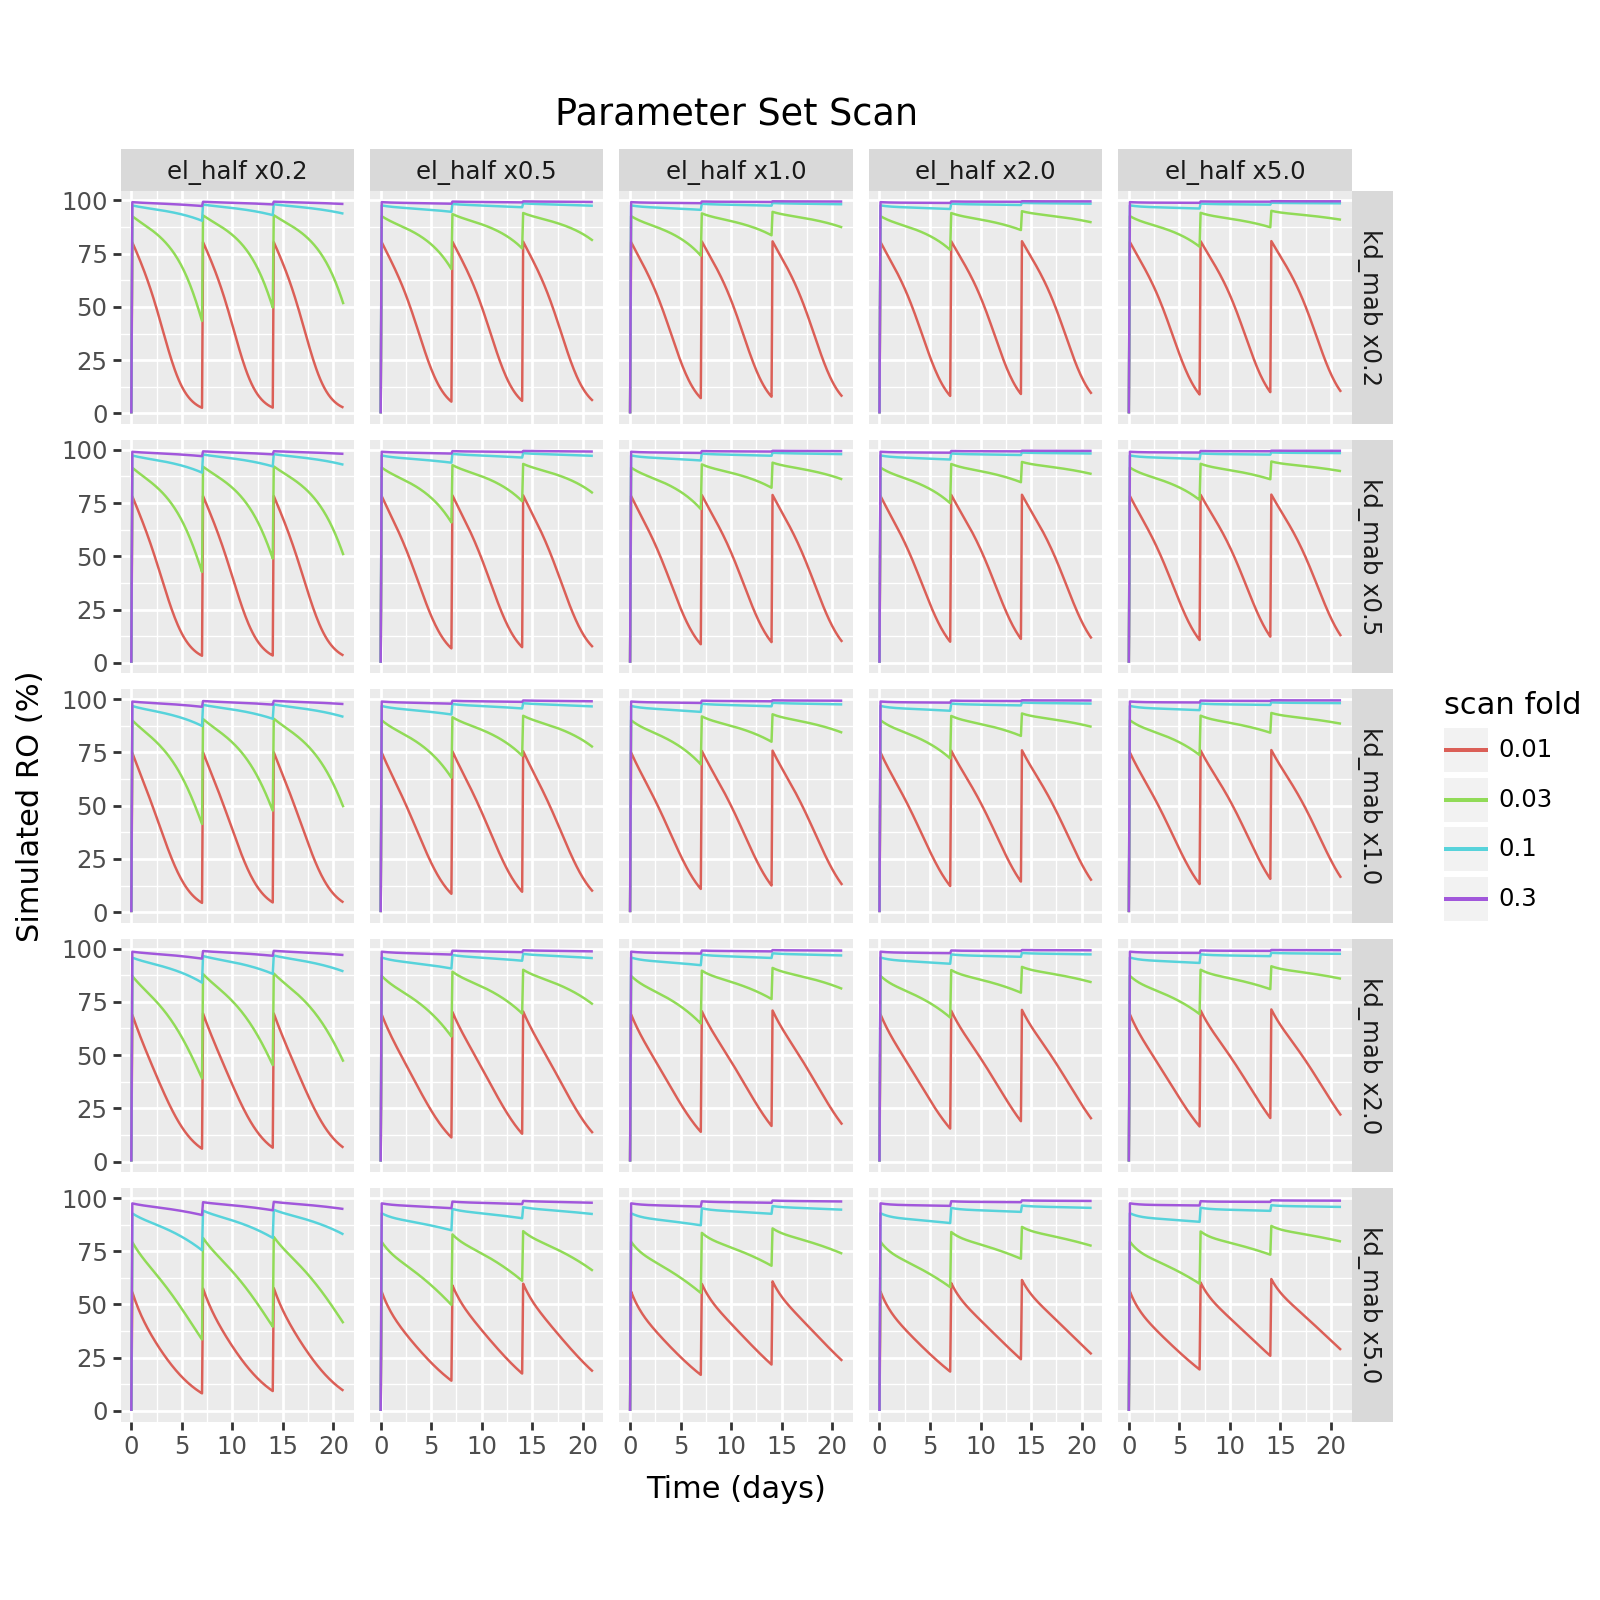

In [15]:
fig = (ggplot()
       + geom_line(data = Tgrid, mapping = aes(x = 't/(3600*24)', y = 'value', color = 'factor(dose_mpk)'))
       + labs(x = 'Time (days)', y = 'Simulated RO (%)', color = 'scan fold', title = 'Parameter Set Scan')
       + facet_grid('label_0 ~ label_1')
       + theme(aspect_ratio = 1, figure_size = (8,8))
)

fig.show()